In [4]:
from itertools import product
import torch
import numpy as np
import tqdm
import math
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *


# h must be n x d, where d >= n
def isometry_gap(h, epsilon = 0, reduce_mean = False):
    if reduce_mean:
        h = h - h.mean(dim=1,keepdim=True)
    G = h @ h.t()
    vals = torch.linalg.eigvalsh(G) + epsilon
    log_vals = torch.log(vals)
    mean_log_vals = torch.mean(log_vals)
    log_mean_vals = torch.log(torch.mean(vals))
    iso_gap = log_mean_vals - mean_log_vals
    return iso_gap

def variance_norms(tensor,reduce_mean=False, dim=0):
    if reduce_mean:
        tensor = tensor - tensor.mean(dim=dim,keepdim=True)
    row_norms = torch.norm(tensor, dim=dim)  # Compute the norms of each row
    mean_norm = torch.mean(row_norms)  # Compute the mean norm
    var_norm = torch.var(row_norms)  # Compute the variance of norms
    return var_norm / mean_norm**2

def run_experiment(config):
    def record_results(model, loader, df, stage, num_batches = 5, reduce_mean = False):
        # Record results
        for i, (images, labels) in enumerate(loader):
            if i > num_batches:
                break
            images = images.to(device)
            labels = labels.to(device)

            outputs, hidden = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            for li, (l, h0, h) in enumerate(hidden):
                h = h.flatten(1)
                ig = isometry_gap(h, reduce_mean=reduce_mean, epsilon=1e-8).item()
                nb = variance_norms(h0, reduce_mean=True, ).item()
                df.append({**config,
                    'l': li,
                    'layer': l,
                    'iso_gap': ig,
                    'norm_bias': nb,
                    'stage': stage,
                    'loss': loss.item(),
                    'accuracy': (predicted == labels).sum().item() / len(labels),
                    'epoch': epoch,
                    'i': i
                })

    # Data preprocessing
    ds_config = dataset_configs[config['dataset']]
    transform = ds_config['transform']
    config['input_size'] = ds_config['input_size']
    config['num_classes'] = ds_config['num_classes']
    clip_norm = None
    if 'clip_norm' in config:
        clip_norm = config['clip_norm']

    train_dataset = getattr(datasets, config['dataset'])(root='./data', train=True, transform=transform, download=True)
    test_dataset = getattr(datasets, config['dataset'])(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Create the model, loss function, and optimizer
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

    df = []
    model = MLP(**config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    for epoch in tqdm.trange(config['num_epochs']):
        if epoch > 0:
            loss = train_model(model, train_loader, criterion, optimizer, clip_norm, device)
            print(f'Epoch [{epoch + 1}/{config["num_epochs"]}], Train Loss: {loss.item():.4f}')
        record_results(model, train_loader, df, 'train', reduce_mean=config['reduce_mean'])

        # Evaluate the model on test data
        accuracy = evaluate_model(model, test_loader, criterion, device)
        # print(f'Test Accuracy of the model on the 10000 test images: {100 * accuracy:.2f}%')
        record_results(model, test_loader, df, 'test', reduce_mean=config['reduce_mean'])

    df = pd.DataFrame(df)
    return df

def run_experiment_grid(config_grid):
    # Generate all possible configurations from the config grid
    config_list = generate_configs(config_grid)

    # Run the experiments for each config
    all_results_df = []
    for config in config_list:
        print(f"Running experiment for config: {config}")
        results_df = run_experiment(config)
        all_results_df.append(results_df)

    # Concatenate the results of all experiments into a single DataFrame
    final_results_df = pd.concat(all_results_df, ignore_index=True)
    final_results_df['beta'] = 0
    for act in final_results_df.activation.unique():
        F = getattr(nn, act)()
        beta = compute_beta(F)
        final_results_df.loc[final_results_df.activation==act, 'beta'] = beta
    final_results_df['mlp_shape'] = final_results_df.apply(lambda x: str(x.hidden_sizes), axis=1)
    return final_results_df


sns.set_theme(style="white")
sns.set_style('ticks')


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.39%


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.75%


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.24%


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.60%


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 1, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.61%


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 1, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.90%


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 1, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.34%


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 1, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.38%


100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 2, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.68%


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 2, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.69%


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 2, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 11.88%


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 2, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.24%


100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 3, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.33%


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 3, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.36%


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 3, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.98%


100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 3, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.03%


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 4, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.98%


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 4, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.36%


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 4, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 12.27%


100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 4, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.30%


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 5, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 11.83%


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 5, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 12.53%


100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 5, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 11.38%


100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 5, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.19%


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 6, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.51%


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 6, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 11.63%


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 6, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.33%


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 6, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.74%


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 7, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.78%


100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 7, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 11.23%


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 7, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.68%


100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 7, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.89%


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 8, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 7.33%


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 8, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.95%


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 8, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.27%


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 8, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.22%


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 9, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 11.81%


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 9, 'activation': 'SELU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 12.07%


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 9, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.79%


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 9, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.93%


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


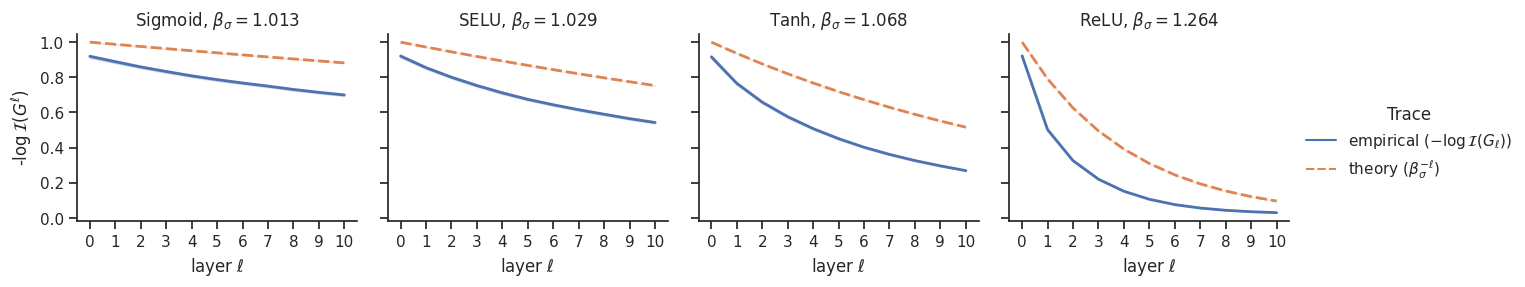

In [23]:
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10',],
    'hidden_sizes': [[5000]*10],
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [1],
    'rerun': range(10),
    'activation': ["Sigmoid", "SELU", "Tanh","ReLU",],#"SELU","SiLU", "ELU", "GELU"],
    'reduce_mean': [False],
    'normalization': ["LN",],
}


final_results_df = run_experiment_grid(config_grid)

# Assuming final_results_df is already defined
df = final_results_df.query("stage == 'train' & dataset == 'CIFAR10' & layer.str.contains('norm')").copy()

# Simplifying the creation of 'activation' and 'layer_idx' columns
df['activation'] = df.apply(lambda x: f"{x.activation}, $\\beta_\\sigma = {x.beta:.3f}$", axis=1)
df['layer_idx'] = df['layer'].str.extract('-(\d+)$').astype(int)

# Creating the empirical and theory traces
df['trace'] = 'empirical ($-\\log\\mathcal{I}(G_\\ell)$)'
df_theory = df.copy()
df_theory['trace'] = 'theory ($\\beta_\\sigma^{-\\ell}$)'
df_theory['iso_gap'] = df_theory.apply(lambda x: 1.0*x.beta**(-x.layer_idx), axis=1)

# Concatenating the dataframes
df = pd.concat([df, df_theory])

# Plotting
g = sns.FacetGrid(df, col="activation",  height=3, aspect=1.1,)
g.map_dataframe(sns.lineplot, x='layer_idx', y='iso_gap', style='trace',hue='trace', linewidth=2, )

# Setting titles with only activation values and adjusting the legends
g.set_titles(col_template="{col_name}")
g.add_legend(title='Trace')
g.set(xlabel='layer $\\ell$', xticks=df['layer_idx'].unique(), ylabel='-$\\log\\mathcal{I}(G^\\ell)$')
plt.savefig('plots/isogap_vs_theory.pdf', bbox_inches='tight')

plt.show()


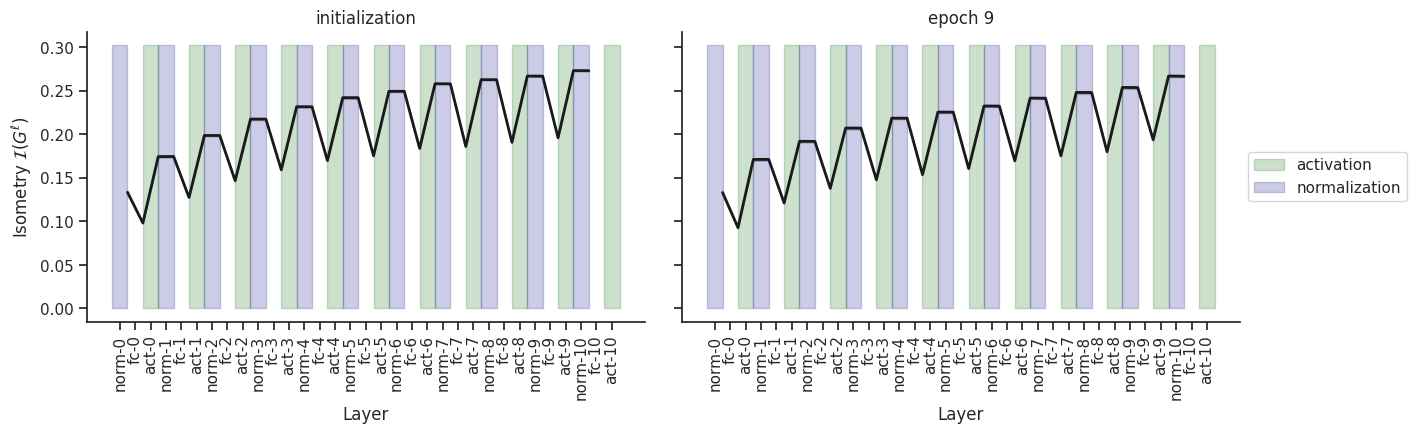

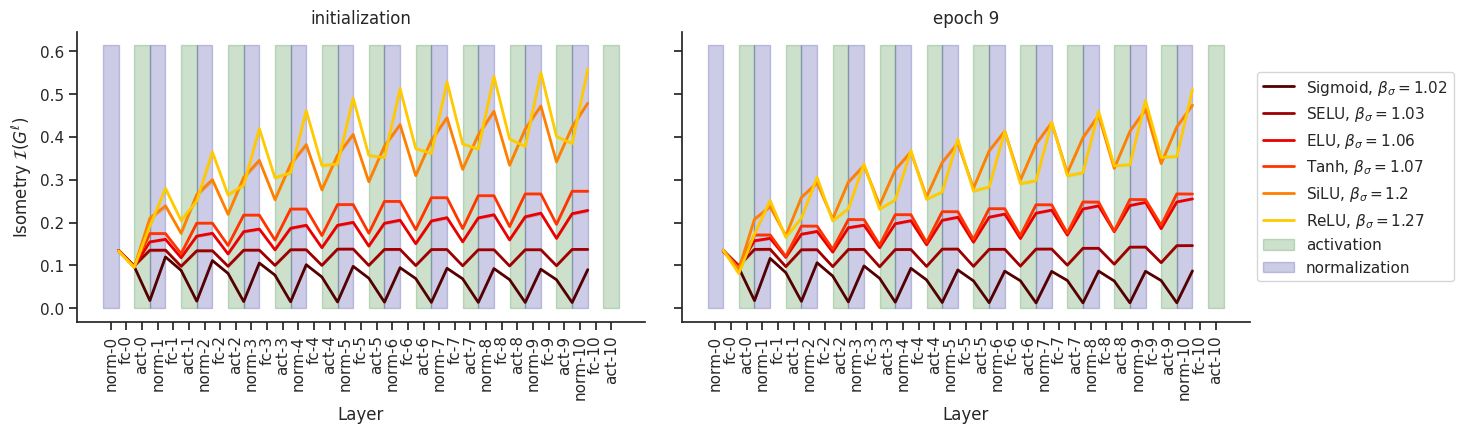

In [30]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10',],
    'hidden_sizes': [[1000]*10],
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [10],
    'rerun': range(5),
    'reduce_mean': [True],
    'activation': ["ReLU", "PReLU", "Tanh", "Identity","SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}


final_results_df = run_experiment_grid(config_grid)
# final_results_df = pd.read_csv('results_training.csv')


df = final_results_df.copy()
df = df.loc[df.stage=='train']
df = df.loc[df.dataset=='CIFAR10']
df = df.loc[df.activation.isin(['Tanh',])]
df['isometry'] = np.exp(-df['iso_gap'])
df = df.loc[df.epoch.isin([0,9])]
df.activation = df.activation.apply(lambda x: x.split(',')[0])
df['activation']  = df.apply(lambda x: f"{x.activation}, $\\beta_\\sigma = {x.beta:.3}$", axis=1)

activation_beta_df = df[['activation', 'beta']].drop_duplicates().sort_values('beta')
colors = sns.color_palette("hot", n_colors=len(activation_beta_df)+2)
palette_dict = {activation: color for activation, color in zip(activation_beta_df['activation'], colors)}
g = sns.FacetGrid(df, col="epoch", height=4, aspect=1.6,)# hue='activation', hue_order=activation_beta_df.activation, palette=palette_dict,)
g.map(sns.lineplot, 'layer', 'isometry', color='k',linewidth=2)#.set(yscale = 'log')
# Adding titles and labels
g.set_axis_labels('Layer', 'Isometry $\\mathcal{I}(G^\\ell)$')

# Iterate through each facet and set custom xticks
for ax, epoch in zip(g.axes.flat, df.epoch.unique()):
    if epoch==0:
        ax.set_title('initialization')
    else:
        ax.set_title(f'epoch {epoch}')
    ax.set_xticks(df['l'].unique()-.5)
    ax.set_xticklabels(df['layer'].unique(), rotation=90, )

    for marker,layer, desc in [('darkgreen','act', 'activation'), ('darkblue','norm', 'normalization')]:#, ('^', 'fc')]:
        df2 = df.loc[df.layer.str.contains(layer)&(df.epoch==epoch)].groupby(['activation', 'l'])['iso_gap'].mean().reset_index()
        for li,l in enumerate(df2.l.unique()):
            if li==0:
                ax.fill_betweenx([0,df.isometry.max()*1.1], l-1, l, color=marker, alpha=0.2, label=desc)
            else:
                ax.fill_betweenx([0,df.isometry.max()*1.1], l-1, l, color=marker, alpha=0.2)

ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.savefig('plots/isometry_init_train_tanh.pdf', bbox_inches='tight')
plt.show()




df = final_results_df.copy()
df = df.loc[df.stage=='train']
df = df.loc[df.dataset=='CIFAR10']
df = df.loc[~df.activation.isin(['GELU',])]
df['isometry'] = np.exp(-df['iso_gap'])
df = df.loc[df.epoch.isin([0,9])]
df.activation = df.activation.apply(lambda x: x.split(',')[0])
df['activation']  = df.apply(lambda x: f"{x.activation}, $\\beta_\\sigma = {x.beta:.3}$", axis=1)

activation_beta_df = df[['activation', 'beta']].drop_duplicates().sort_values('beta')
colors = sns.color_palette("hot", n_colors=len(activation_beta_df)+2)
palette_dict = {activation: color for activation, color in zip(activation_beta_df['activation'], colors)}
g = sns.FacetGrid(df, col="epoch", height=4, aspect=1.6, hue='activation', hue_order=activation_beta_df.activation, palette=palette_dict,)
g.map(sns.lineplot, 'layer', 'isometry', linewidth=2)#.set(yscale = 'log')
# Adding titles and labels
g.set_axis_labels('Layer', 'Isometry $\\mathcal{I}(G^\\ell)$')

# Iterate through each facet and set custom xticks
for ax, epoch in zip(g.axes.flat, df.epoch.unique()):
    if epoch==0:
        ax.set_title('initialization')
    else:
        ax.set_title(f'epoch {epoch}')
    ax.set_xticks(df['l'].unique()-.5)
    ax.set_xticklabels(df['layer'].unique(), rotation=90, )

    for marker,layer, desc in [('darkgreen','act', 'activation'), ('darkblue','norm', 'normalization')]:#, ('^', 'fc')]:
        df2 = df.loc[df.layer.str.contains(layer)&(df.epoch==epoch)].groupby(['activation', 'l'])['iso_gap'].mean().reset_index()
        for li,l in enumerate(df2.l.unique()):
            if li==0:
                ax.fill_betweenx([0,df.isometry.max()*1.1], l-1, l, color=marker, alpha=0.2, label=desc)
            else:
                ax.fill_betweenx([0,df.isometry.max()*1.1], l-1, l, color=marker, alpha=0.2)

ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.savefig('plots/isometry_init_train.pdf', bbox_inches='tight')
plt.show()

Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 7.75%


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [512, 1024, 2048, 4096, 8192], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 12.89%


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [8192, 4096, 2048, 1024, 512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 7.01%


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [1024, 2048, 1024, 2048, 1024], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.01%


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.52%


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [512, 1024, 2048, 4096, 8192], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.12%


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [8192, 4096, 2048, 1024, 512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.39%


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1024, 2048, 1024, 2048, 1024], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.89%


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


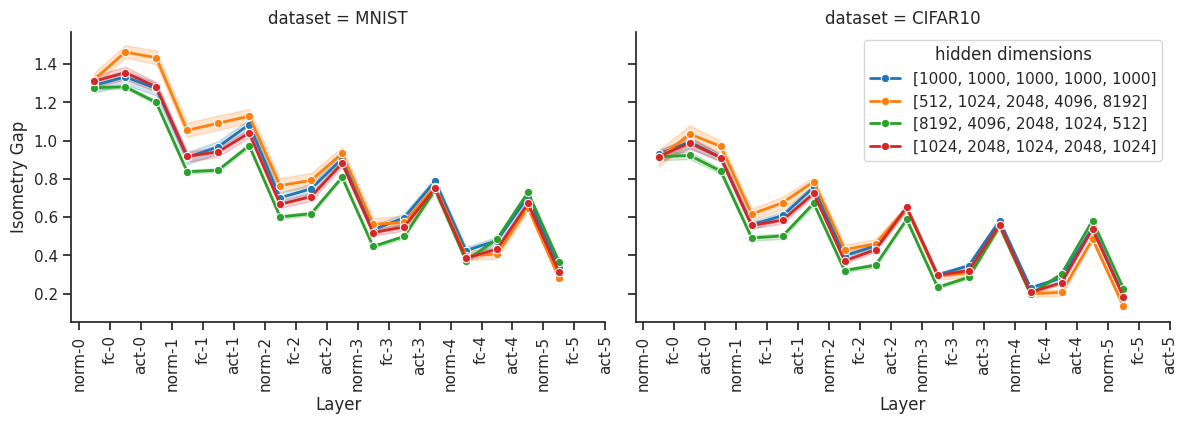

In [3]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['MNIST', 'CIFAR10',],
    'hidden_sizes': [
        [1000,]*5, 
        [int(2**(l+9)) for l in range(5)], 
        [2**(13-l) for l in range(5)], 
        [1024*2**(l%2) for l in range(5)]],
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [1],
    'rerun': range(1),
    'reduce_mean': [False],
    'activation': ["ReLU"], #["ReLU", "PReLU", "Tanh", "Identity","SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}

final_results_df = run_experiment_grid(config_grid)


df = final_results_df
df = df.loc[df.stage=='train']
g = sns.FacetGrid(df, col="dataset", col_wrap=2, height=4, aspect=1.5, hue='mlp_shape', palette="tab10")#, hue_order=activation_beta_df.activation, palette=palette_dict,)
g.map(sns.lineplot, 'layer', 'iso_gap', linewidth=2, marker='o',)
g.set(xlabel='Layer', ylabel='Isometry Gap')
for ax in g.axes.flat:
    ax.set_xticks(df['l'].unique()-.5)
    ax.set_xticklabels(df['layer'].unique(), rotation=90, )

plt.legend(title='hidden dimensions')
plt.savefig('plots/mlp_shape.pdf', bbox_inches='tight')
plt.show()

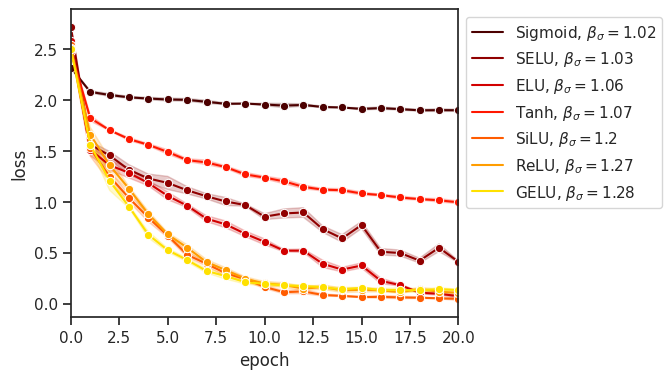

In [38]:

# Define the configuration grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10'],
    'reduce_mean': [False],
    'hidden_sizes': [[1000]*10],
    'batch_size': [512],
    'learning_rate': [0.01],
    'num_epochs': [10],
    'rerun': range(5),
    'activation': ["Sigmoid", "Tanh", "ReLU","SELU","SiLU", "ELU", "GELU"],#['ReLU', 'Sigmoid', 'Tanh'], 
    'normalization': ["LN"],
}

# Uncomment the next line to run the experiment grid
# final_results_df = run_experiment_grid(config_grid)
# final_results_df.to_csv('results_training.csv')
# Uncomment the next line to read data from a CSV file
final_results_df = pd.read_csv('results_training.csv')

df = final_results_df.copy()
df = df.query("stage == 'train' & layer.str.contains('norm')").copy()

df['activation'] = df.activation.str.split(',').str[0]
df['layer_idx'] = df['layer'].str.extract('-(\d+)$').astype(int)
df['activation'] = df.apply(lambda x: f"{x.activation}, $\\beta_\\sigma = {x.beta:.3}$", axis=1)

# Creating a palette based on activation and beta values
activation_beta_df = df[['activation', 'beta']].drop_duplicates().sort_values('beta')
colors = sns.color_palette("hot", n_colors=len(activation_beta_df)+2)
palette_dict = dict(zip(activation_beta_df['activation'], colors))

# Plotting
plt.figure(figsize=(5, 4))
ax = sns.lineplot(data=df, x='epoch', y='loss', hue='activation',errorbar="sd",
                  hue_order=activation_beta_df.activation, palette=palette_dict, marker='o')
ax.set_xlim(0, 20)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('plots/beta0_train_loss.pdf', bbox_inches='tight')
plt.show()
